<a href="https://colab.research.google.com/github/bala-baskar/aiml_tech_courses/blob/main/pytorch/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises


## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 34.11 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [27]:
# Use of Auto transform based on pretrained models
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x792200253d90>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


In [9]:
from torchinfo import summary
summary(model=model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [11]:
summary(model=model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [12]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [14]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 8.903 seconds


### Make predictions on the entire test dataset with the model

In [17]:
# Prediction
model_0.eval()
test_loss, test_acc = 0, 0
with torch.inference_mode():
  for X_batch, y_batch in test_dataloader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred_test = model_0(X_batch)
    loss = loss_fn(y_pred_test,y_batch)
    test_loss += loss
    y_pred_class = torch.softmax(y_pred_test,dim=1).argmax(dim=1)
    test_acc += (y_pred_class == y_batch).sum().item()/len(y_batch)

print(f"Test loss: {test_loss/len(test_dataloader)}, Test accuracy: {(test_acc/len(test_dataloader))*100.0}")

Test loss: 0.6243551969528198, Test accuracy: 89.67803030303031


### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [18]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.9 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [19]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [21]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# Model prediction in batches
model_0.eval()
test_loss, test_acc = 0, 0
with torch.inference_mode():
  for X_batch, y_batch in test_dataloader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred_test = model_0(X_batch)
    loss = loss_fn(y_pred_test,y_batch)
    test_loss += loss
    y_pred_class = torch.softmax(y_pred_test,dim=1).argmax(dim=1)
    test_acc += (y_pred_class == y_batch).sum().item()/len(y_batch)
    confmat.update(y_pred_class.to("cpu"), y_batch.to("cpu"))

print(f"Test loss: {test_loss/len(test_dataloader)}, Test accuracy: {(test_acc/len(test_dataloader))*100.0}")

Test loss: 0.6243551969528198, Test accuracy: 89.67803030303031


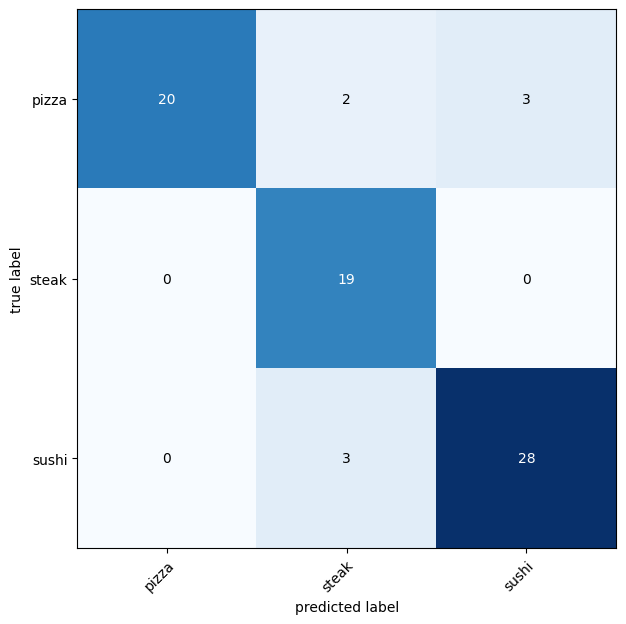

In [22]:
# 3. Plot the confusion matrix
confmat_tensor = confmat.compute()
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);